# Connect to GDrive for Dataset



In [ ]:
# prompt: connect to gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clone Repository

In [ ]:
!git clone https://github.com/divamgupta/image-segmentation-keras.git

Cloning into 'image-segmentation-keras'...
remote: Enumerating objects: 1239, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 1239 (delta 24), reused 25 (delta 5), pack-reused 1188
Receiving objects: 100% (1239/1239), 4.62 MiB | 6.58 MiB/s, done.
Resolving deltas: 100% (792/792), done.


In [ ]:
%cd image-segmentation-keras

/content/image-segmentation-keras/image-segmentation-keras


# Install Dependencies

In [ ]:
!pip list | grep keras-segmentation > requirements.txt

# Model Training

In [ ]:
from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes = 30, input_height = 352, input_width = 480)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
from imgaug import augmenters as iaa

def custom_augmentation():
    return iaa.Sequential(
    [
        # Apply the following augmenters to most images:
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 50% of all images
        iaa.Multiply((0.5, 1.5)), # change brightness, doesn't affect BBs
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.LinearContrast((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
    ])

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer
from keras_segmentation.models.unet import resnet50_unet


def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice Loss between the ground truth and predictions.

    Parameters:
    - y_true: Ground truth labels (shape: [batch_size, height, width, num_classes])
    - y_pred: Predicted labels (shape: [batch_size, height, width, num_classes])
    - smooth: Smoothing factor to avoid division by zero

    Returns:
    - Dice Loss value
    """
    # Flatten the tensors
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Calculate intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    # Compute Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss
    return 1 - dice

In [ ]:
from keras.callbacks import ModelCheckpoint
import os
from tensorflow.keras.optimizers import Adam

checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/IndonesiaAI/Project3_CV_ImageSegmentation/checkpoints/model_{epoch:02d}.weights.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok = True)

checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only = True)

model.train(
    train_images = "/content/drive/MyDrive/Colab Notebooks/IndonesiaAI/Project3_CV_ImageSegmentation/Datasets/images_prepped_train_cleaned",
    train_annotations = "/content/drive/MyDrive/Colab Notebooks/IndonesiaAI/Project3_CV_ImageSegmentation/Datasets/annotations_prepped_train",
    checkpoints_path = checkpoint_path,
    epochs = 5,
    do_augment = True,
    custom_augmentation = custom_augmentation,
    callbacks = [checkpoint]
)
# Compile the model with Dice Loss
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy','dice_loss']
)

Verifying training dataset


100%|██████████| 367/367 [03:51<00:00,  1.59it/s]


Dataset verified! 
Epoch 1/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 76s 108ms/step - accuracy: 0.6116 - loss: 1.4637
Epoch 2/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 56s 109ms/step - accuracy: 0.7202 - loss: 0.8823
Epoch 3/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 49s 96ms/step - accuracy: 0.7564 - loss: 0.7553
Epoch 4/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 48s 94ms/step - accuracy: 0.7807 - loss: 0.6781
Epoch 5/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 49s 95ms/step - accuracy: 0.7948 - loss: 0.6310


# Monitoring & Evaluation

In [ ]:
# Extract accuracy and loss values
accuracy = model.history.history['accuracy']
loss = model.history.history['loss']

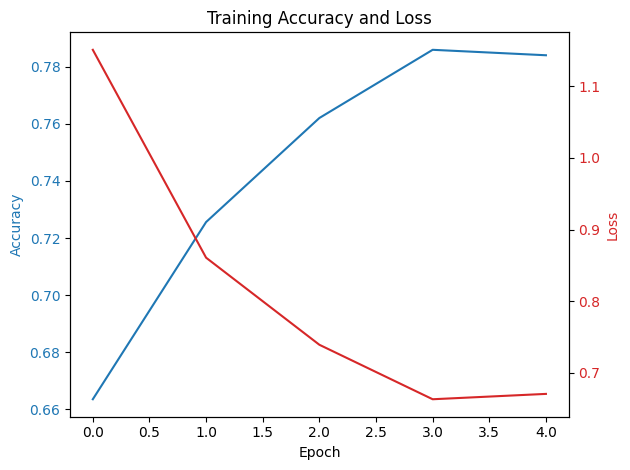

In [ ]:
# prompt: plot train accuracy and loss in keras model and combine it in one plot with accuracy in left side y axis with blue color and loss in right side y axis with red color

# Create a figure and axes
fig, ax1 = plt.subplots()

# Plot accuracy on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(accuracy, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis for loss on the right y-axis
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(loss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set title and display the plot
plt.title('Training Accuracy and Loss')
fig.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


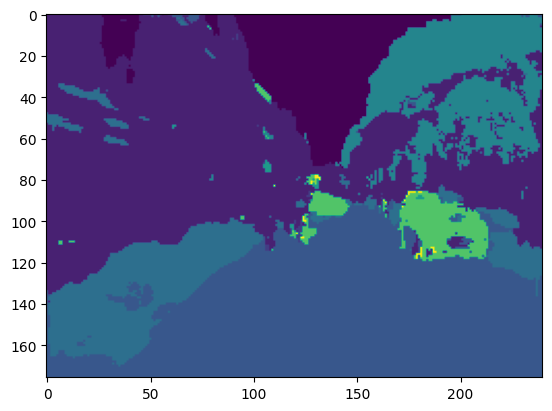

In [ ]:
out = model.predict_segmentation(
    inp = "/content/drive/MyDrive/Colab Notebooks/IndonesiaAI/Project3_CV_ImageSegmentation/Datasets/images_prepped_test/0016E5_07959.png"
)
plt.imshow(out);

In [ ]:
model_unet.load_weights("/content/resnet_unet.weights.h5")

In [ ]:
from IPython.display import Image

o = model.predict_segmentation(
    inp = "/content/drive/MyDrive/Colab Notebooks/IndonesiaAI/Project3_CV_ImageSegmentation/Datasets/images_prepped_test/0016E5_07959.png",
    out_fname = "/content/drive/MyDrive/Colab Notebooks/IndonesiaAI/Project3_CV_ImageSegmentation/out.png",
    overlay_img = True,
    show_legends =True,
    class_names = ["Sky","Building","Pole","Road","pavement","Tree","SignSymbol","Fence","Car","Pedestrian","Bicylist"]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


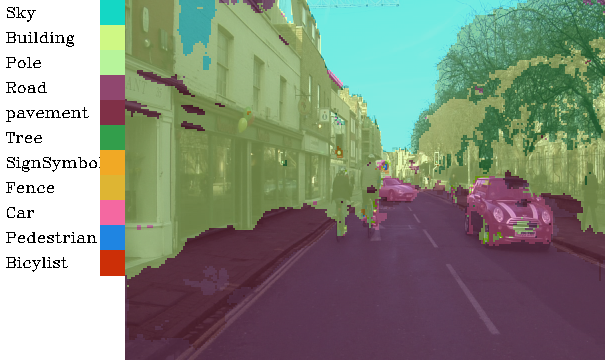

In [ ]:
Image("/content/drive/MyDrive/Colab Notebooks/IndonesiaAI/Project3_CV_ImageSegmentation/out.png")

# Save Model in H5 format

In [ ]:
# prompt: export weight with best accuracy and last epoch from keras model

# Find the epoch with the best accuracy
best_epoch = np.argmax(accuracy)

# Load weights from the best epoch
best_checkpoint_path = checkpoint_path.format(epoch=best_epoch + 1)
model.load_weights(best_checkpoint_path)

# Save the model with best accuracy
model.save("/content/temp_output/best_model.h5")

# Save the model from the last epoch
model.save("/content/temp_output/last_epoch_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_epoch = np.argmax(accuracy)
best_epoch

3

# Inference

## install inference dependencies

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing 

URL Example:

Video

https://drive.google.com/uc?export=download&id=14VViiopf5R1Ua4wlLFpK2eHJ-8zcf72N

Image

https://drive.google.com/uc?export=download&id=152mL-y9eJV1BPcU99Y6egWf-XUHg9MAf

https://drive.google.com/uc?export=download&id=1D4QgG8eVT40Uhod-rAK1YZ1vMFH9PxSt

In [ ]:
model_unet = vgg_unet(n_classes = 30, input_height = 352, input_width = 480)
model_unet.predict_segmentation

<bound method predict of <Functional name=functional_7, built=True>>

In [ ]:
%mkdir temp_output/input/
%mkdir temp_output/output/

mkdir: cannot create directory ‘temp_output/input/’: No such file or directory
mkdir: cannot create directory ‘temp_output/output/’: No such file or directory


## implementation

In [ ]:
import gradio as gr
import cv2
import urllib
from urllib.request import urlopen
import numpy as np
from keras_segmentation.models.unet import resnet50_unet
from keras_segmentation.predict import predict_video as keras_predict_video
import os

model_unet = resnet50_unet(n_classes = 30, input_height = 352, input_width = 480)
model_unet.load_weights("/content/resnet_unet.weights.h5")
input_address = "/content/temp_output/input/"
output_address = "/content/temp_output/output/"

class_names_label = ["Sky","Building","Pole","Road","pavement","Tree","SignSymbol","Fence","Car","Pedestrian","Bicylist"]

def initialize():
  os.remove("/content/temp_output/output/out.mp4")
  os.remove("/content/temp_output/output/out.png")
  os.remove("/content/temp_output/input/in.png")
  os.remove("/content/temp_output/input/in.mp4")


def url_to_image(url):
    # download the image from url and save to file
    open = urlopen(url)
    image = np.asarray(bytearray(open.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # save the image to file
    cv2.imwrite(input_address + 'in.png', image)
    # return the file address
    return input_address + 'in.png'

def url_to_video(url, readFlag=cv2.IMREAD_COLOR):
    vcap = cv2.VideoCapture(url)
    width = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(input_address + 'in.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    if not vcap.isOpened():
      print("Error opening video stream or file")
      return None
    while(True):
      # Capture frame-by-frame
      ret, frame = vcap.read()
      #print cap.isOpened(), ret
      if frame is not None:
          # Display the resulting frame
          cv2.imshow('frame',frame)
      else:
          gr.Error("There are no frame")
          return None
    # When everything done, release the capture
    vcap.release()
    return input_address + 'in.mp4'

def predict_image(img, model_type):
    out = model_unet.predict_segmentation (
        inp = img,
        out_fname = output_address + 'out.png',
        overlay_img = True,
        show_legends =True,
        class_names = class_names_label
    )
    # for returning image
    return output_address + 'out.png'

def predict_video(video, model_type):
    out = keras_predict_video (
        model = model_unet,
        inp = video,
        output = output_address + 'out.mp4',
        overlay_img = True,
        class_names = class_names_label
    )
    # for returning image
    return output_address + 'out.mp4'

def predict_image_from_url(url, model_type):
    return predict_image(url_to_image(url), model_type)

def predict_video_from_url(url, model_type):
    return predict_video(url, model_type)

def predict_image_from_file(file, model_type):
    return predict_image(file, model_type)

def predict_video_from_file(file, model_type):
    return predict_video(file, model_type)

with gr.Blocks() as demo:
    mode = gr.Radio(["Image URL","Video URL", "Image", "Video"], value="URL", label="Choose Input Type")

    mode.change(initialize)

    @gr.render(inputs=mode)
    def interface(text):
        if text == "Image URL":
            input = gr.Textbox(label="Image URL")
            fn = predict_image_from_url
            output = gr.Image(label="Output Image")
            btn = gr.Button("Predict")
            # btn.click(fn, inputs=[input, model_type], outputs=[output])
            btn.click(fn, inputs=[input], outputs=[output])
            return input, btn, output
        elif text == "Video URL":
            input = gr.Textbox(label="Video URL")
            fn = predict_video_from_url
            output = gr.Video()
            btn = gr.Button("Predict")
            # btn.click(fn, inputs=[input, model_type], outputs=[output])
            btn.click(fn, inputs=[input], outputs=[output])
            return input, btn, output
        elif text == "Image":
            input = gr.Image(sources=['upload', 'webcam', 'clipboard'], type="filepath", label="Image Input")
            fn = predict_image_from_file
            output = gr.Image(label="Output Image")
            btn = gr.Button("Predict")
            # btn.click(fn, inputs=[input, model_type], outputs=[output])
            btn.click(fn, inputs=[input], outputs=[output])
            return input, btn, output
        elif text == "Video":
            input = gr.Video(sources=['upload', 'webcam'], label="Video Input")
            fn = predict_video_from_file
            output = gr.Video(label="Output Video")
            btn = gr.Button("Predict")
            # btn.click(fn, inputs=[input, model_type], outputs=[output])
            btn.click(fn, inputs=[input], outputs=[output])
            return input, btn, output


demo.launch(debug=True)

94653016/94653016 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c25402ded96feea741.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 285, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1923, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1508, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
FPS: 0.5034059654444174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
FPS: 2.563091228190249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
FPS: 2.4438941452176213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
FPS: 2.6364264365251224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
FPS: 2.6810223709156364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
FPS: 2.721107359821876
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
FPS: 2.4332649740244294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
FPS: 2.387795684631145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
FPS: 2.458106504367599
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
FPS: 2.498965691461473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
FPS: 2.5149778441354416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
FPS: 2.5015396415196856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
FPS: 2.6497325189713163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
FPS: 2.741781950655424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
FPS: 2.693952790518282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
FPS: 2.5894313912153395
1/

/usr/local/lib/python3.10/dist-packages/gradio/components/video.py:327: UserWarning: Video does not have browser-compatible container or codec. Converting to mp4.
  warnings.warn(
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 285, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1923, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1508, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packag

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c25402ded96feea741.gradio.live


In [ ]:
!gradio deploy

Creating new Spaces Repo in '/content/image-segmentation-keras'. Collecting metadata, press Enter to
accept default value.
Enter Spaces app title [image-segmentation-keras]: 
Enter Gradio app file : 
╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/gradio/cli/commands/deploy_space.py:157 in deploy        │
│                                                                                                  │
│   154 │   │   print(                                                                             │
│   155 │   │   │   f"Creating new Spaces Repo in '{repo_directory}'. Collecting metadata, press   │
│   156 │   │   )                                                                                  │
│ ❱ 157 │   │   configuration = add_configuration_to_readme(                                       │
│   158 │   │   │   title,                                                                   